# Retail Demand Forecasting Analysis

This notebook contains the analysis for the ML Zoomcamp 2024 Competition focusing on retail demand forecasting.

## Data Preparation

In this section, we will:
1. Load and examine the raw data
2. Check for missing values
3. Analyze data types and basic statistics
4. Handle any data format issues

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option("display.max_columns", None)

## Data Loading

Loading all CSV files from the competition dataset:

In [2]:
# Load all CSV files
actual_matrix = pd.read_csv('../data/actual_matrix.csv', index_col=0)
catalog = pd.read_csv('../data/catalog.csv', index_col=0)
discounts = pd.read_csv('../data/discounts_history.csv', index_col=0)
markdowns = pd.read_csv('../data/markdowns.csv', index_col=0)
online = pd.read_csv('../data/online.csv', index_col=0)
price_history = pd.read_csv('../data/price_history.csv', index_col=0)
sales = pd.read_csv('../data/sales.csv', index_col=0)
stores = pd.read_csv('../data/stores.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)

In [3]:
# Display basic information about each dataset
for name, df in {
    'Actual Matrix': actual_matrix,
    'Catalog': catalog,
    'Discounts History': discounts,
    'Markdowns': markdowns,
    'Online': online,
    'Price History': price_history,
    'Sales': sales,
    'Stores': stores,
    'Test': test
}.items():
    print(f"\n{name} Dataset:")
    print(f"Shape: {df.shape}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nSample data:")
    print(df.head(2))
    print("\nData Info:")
    df.info()


Actual Matrix Dataset:
Shape: (35202, 3)

Columns:
['item_id', 'date', 'store_id']

Sample data:
        item_id        date  store_id
0  c578da8e8841  2019-10-17         1
1  4dd2b686802c  2019-10-17         1

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 35202 entries, 0 to 35201
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item_id   35202 non-null  object
 1   date      35202 non-null  object
 2   store_id  35202 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB

Catalog Dataset:
Shape: (219810, 8)

Columns:
['item_id', 'dept_name', 'class_name', 'subclass_name', 'item_type', 'weight_volume', 'weight_netto', 'fatness']

Sample data:
        item_id                 dept_name          class_name  \
0  da17e2d5feda  БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ  БУМАЖНАЯ ПРОДУКЦИЯ   
1  614de2b96018  БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ    ВАТНАЯ ПРОДУКЦИЯ   

      subclass_name item_type  weight_volume  weight_netto  fat

## Initial Data Analysis

Key aspects to analyze:
1. Data completeness (missing values)
2. Data types and potential type conversions
3. Value distributions
4. Temporal patterns (for time-series data)
5. Relationships between different datasets

In [4]:
# Analyze missing values in each dataset
print("Missing Values Analysis:\n")

for name, df in {
    'Actual Matrix': actual_matrix,
    'Catalog': catalog,
    'Discounts History': discounts,
    'Markdowns': markdowns,
    'Online': online,
    'Price History': price_history,
    'Sales': sales,
    'Stores': stores,
    'Test': test
}.items():
    missing = df.isnull().sum()
    if missing.any():
        print(f"\n{name} Dataset Missing Values:")
        print(missing[missing > 0])
    else:
        print(f"\n{name} Dataset: No missing values")

Missing Values Analysis:


Actual Matrix Dataset: No missing values

Catalog Dataset Missing Values:
item_type        176224
weight_volume    136858
weight_netto     170853
fatness          212598
dtype: int64

Discounts History Dataset Missing Values:
promo_type_code    317846
dtype: int64

Markdowns Dataset: No missing values

Online Dataset: No missing values

Price History Dataset: No missing values

Sales Dataset: No missing values

Stores Dataset: No missing values

Test Dataset: No missing values


## Data Visualization

Let's create some basic visualizations to understand our data better:

In [5]:
sales.head()

,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,293375605257,1.000,47.86,47.86,1
1,2023-08-04,a66fdf2c0ae7,3.000,49.60,148.80,1
2,2023-08-04,daa46ef49b7a,0.822,379.00,311.54,1
3,2023-08-04,a3b49c1bf758,1.000,129.00,129.00,1
4,2023-08-04,ab611c5cef62,7.000,79.90,559.30,1


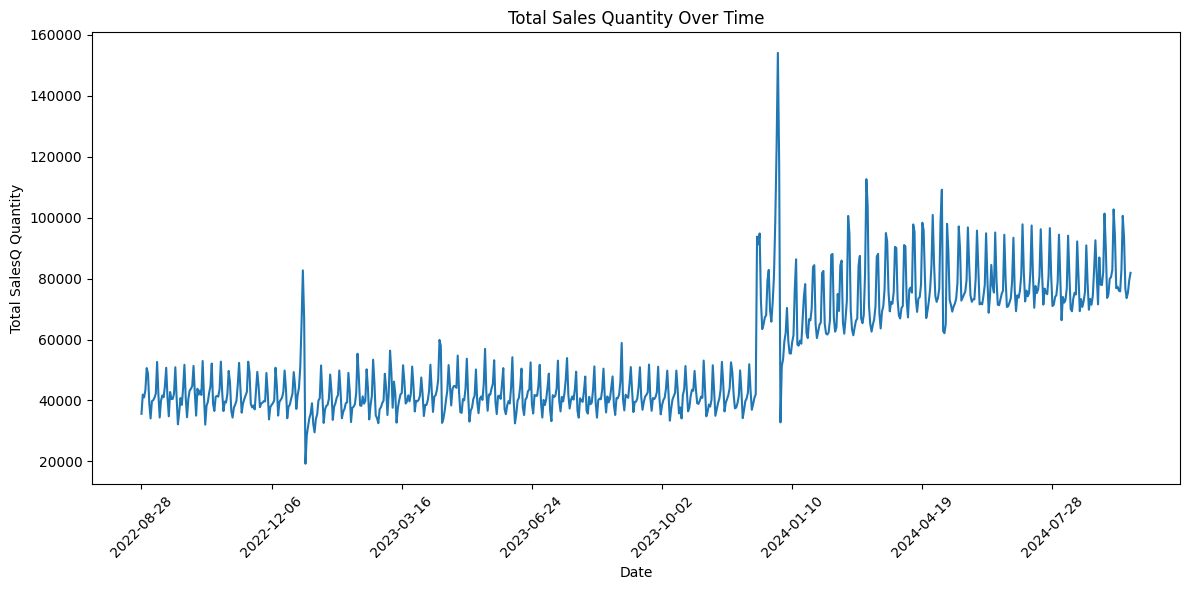

In [6]:
# Daily Sales Overview
plt.figure(figsize=(12, 6))
sales.groupby('date')['quantity'].sum().plot(kind='line')
plt.title('Total Sales Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Total SalesQ Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

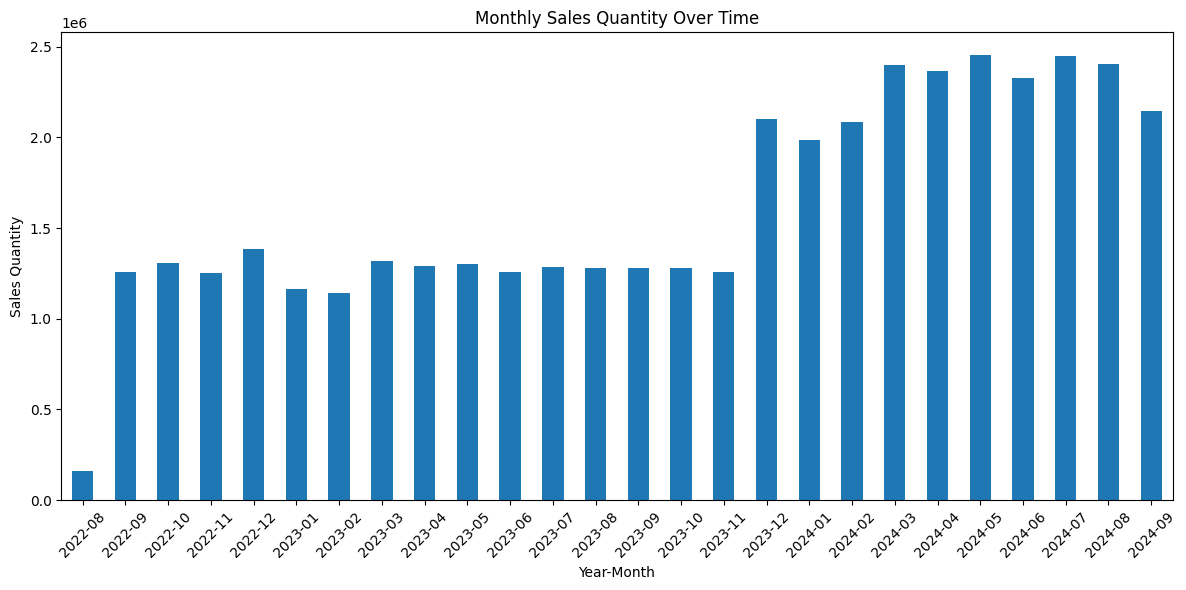

In [7]:
# sales.info()
sales['year_month'] = sales['date'].str[:7]
# Group by the new 'year_month' column and calculate the cumulative sum
monthly_sales = sales.groupby('year_month')['quantity'].sum()

# Plot the accumulated sum
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar')
plt.title('Monthly Sales Quantity Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Sales Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
top_sold_items = sales.groupby('item_id')['quantity'].sum().sort_values(ascending=False)
top_sold_items

item_id
b0d24502fb66    2022732.000
9a7e315f3f42     563403.013
63161948a95a     434289.000
e5b2b6f57ea7     358707.000
0973df3ff57f     344912.918
                   ...     
d27f73981eab          0.000
83932c71b0d5          0.000
78e039e32681          0.000
4c75fad3b4e7          0.000
0235e9b39818          0.000
Name: quantity, Length: 28182, dtype: float64

In [9]:
# Calculate the IQR range
Q1 = top_sold_items.quantile(0.25)
Q3 = top_sold_items.quantile(0.75)
IQR = Q3 - Q1

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR (Interquartile Range): {IQR}")

Q1 (25th percentile): 21.0
Q3 (75th percentile): 699.0
IQR (Interquartile Range): 678.0


## Data Cleaning

In this section, we will:
1. Remove or handle outliers
2. Handle missing values
3. Format dates and categorical variables
4. Create any necessary derived features

In [11]:
# combine offline and online data
sales['channel'] = 'offline'
online['channel'] = 'online'
all_sales = pd.concat([sales, online], ignore_index=True)

In [12]:
# Convert date to datetime
all_sales['date'] = pd.to_datetime(all_sales['date'])

# Create basic time features
all_sales['year'] = all_sales['date'].dt.year
all_sales['month'] = all_sales['date'].dt.month
all_sales['day'] = all_sales['date'].dt.day
all_sales['day_of_week'] = all_sales['date'].dt.dayofweek

In [13]:
# Fill missing values in catalog
catalog['dept_name'] = catalog['dept_name'].fillna('Unknown')
catalog['class_name'] = catalog['class_name'].fillna('Unknown')

# Merge with catalog and stores
all_sales = all_sales.merge(catalog[['item_id', 'dept_name', 'class_name']], 
                            on='item_id', how='left')
all_sales = all_sales.merge(stores[['store_id', 'format', 'city']], 
                            on='store_id', how='left')

In [14]:
all_sales.head()

,date,item_id,quantity,price_base,sum_total,store_id,year_month,channel,year,month,day,day_of_week,dept_name,class_name,format,city
0,2023-08-04,293375605257,1.000,47.86,47.86,1,2023-08,offline,2023,8,4,4,ПРИКАССА,ЖЕВАТЕЛЬНАЯ РЕЗИНКА,Format-1,City1
1,2023-08-04,a66fdf2c0ae7,3.000,49.60,148.80,1,2023-08,offline,2023,8,4,4,ЛИМОНАДЫ,НЕКОЛОСОДЕРЖАЩИЕ,Format-1,City1
2,2023-08-04,daa46ef49b7a,0.822,379.00,311.54,1,2023-08,offline,2023,8,4,4,СЛОЙКА,СЛОЙКА,Format-1,City1
3,2023-08-04,a3b49c1bf758,1.000,129.00,129.00,1,2023-08,offline,2023,8,4,4,ПЕРСОНАЛЬНЫЙ УХОД,ДЛЯ ВАННЫ И ДУША,Format-1,City1
4,2023-08-04,ab611c5cef62,7.000,79.90,559.30,1,2023-08,offline,2023,8,4,4,СОВРЕМЕННАЯ МОЛОЧНАЯ КАТЕГОРИЯ,ЙОГУРТЫ,Format-1,City1


## Baseline
Since out goal is to predit the next month sales, which is 2024-10. We could use the monthly average to create the baseline prediction.

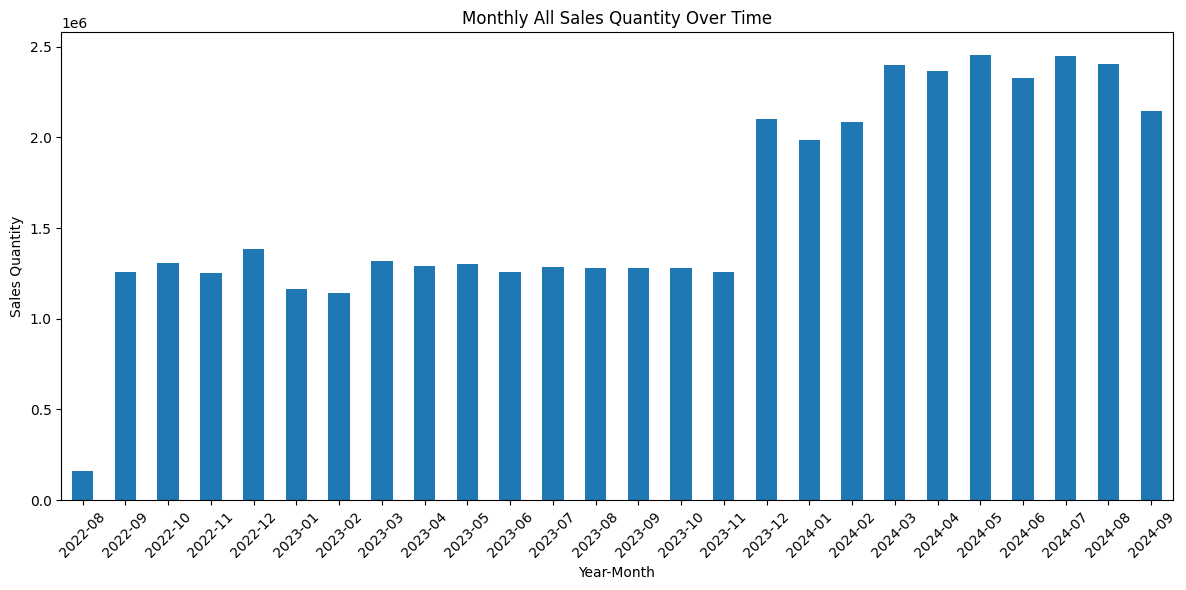

: 

In [ ]:
all_sales = sales.groupby('year_month')['quantity'].sum()

# Plot the accumulated sum
plt.figure(figsize=(12, 6))
all_sales.plot(kind='bar')
plt.title('Monthly All Sales Quantity Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Sales Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

since there is a sale gap between 2023-11 and 2023-12, we will only use the data since 2023-12 as our average.

#

In [ ]:
# Parse and filter data for specified date range
mask = (all_sales['date'] >= '2023-12-01') & (all_sales['date'] <= '2024-09-30')
sales_filtered = all_sales.loc[mask].copy()  # Create copy to avoid SettingWithCopyWarning

print(f"Using {len(sales_filtered)} sales records from Dec 2023 to Sep 2024")

# 2. Compute monthly averages
# Convert to monthly period for grouping
sales_filtered['year_month'] = sales_filtered['date'].dt.to_period('M')
monthly_avgs = (
    sales_filtered.groupby(['item_id', 'store_id'])['quantity']
    .mean()
    .reset_index()
    .rename(columns={'quantity': 'monthly_avg'})
)

print(f"Computed averages for {len(monthly_avgs)} item-store combinations")